## VQ-VAE MNIST

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/home/rowel/anaconda3/envs/fuyu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the VQ-VAE encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, embedding_dim, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define the VQ-VAE decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(embedding_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x


In [3]:
class Quantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Quantizer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1./num_embeddings, 1./num_embeddings)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
    def forward(self, z_e):
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_shape = z_e.shape
        flat_e = z_e.view(-1, self.embedding_dim)


        distances = (torch.sum(flat_e**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_e, self.embedding.weight.t()))
        
        
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z_e.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        z_q = torch.matmul(encodings, self.embedding.weight).view(z_e_shape) 
        z_q = z_e + (z_q - z_e).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        
        return z_q, encoding_indices



In [4]:
class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_embeddings):
        super(VQVAE, self).__init__()
        
        # Define the VQ-VAE encoder
        self.encoder = Encoder(input_dim, hidden_dim, embedding_dim)
        
        # Define the VQ-VAE quantizer
        self.quantizer = Quantizer(num_embeddings, embedding_dim)
        
        # Define the VQ-VAE decoder
        self.decoder = Decoder(embedding_dim, hidden_dim, input_dim)
        
    def forward(self, x):
        # Encode the input
        z_e = self.encoder(x)
        
        # Quantize the encoded input
        z_q, indices = self.quantizer(z_e)
        
        # Decode the quantized input
        x_hat = self.decoder(z_q)
        
        return x_hat, z_e, z_q, indices


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(1, 128, 64, 512).to(device)


In [6]:
random_input = torch.randn(1, 1, 28, 28).to(device)
z_e = model.encoder(random_input)
z_q, indeces = model.quantizer(z_e)
x_hat = model.decoder(z_q)
#x_hat, z_e, z_q, indices = model(random_input)


In [7]:
# Set the number of epochs
num_epochs = 100

# Create an optimizer
optimizer = optim.Adam(model.parameters())
# Print the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    r_loss = 0
    c_loss = 0
    l_loss = 0  
    total = 0 
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the data to the device
        data = data.to(device)
        total += data.size(0)
        
        # Forward pass
        x_hat, z_e, z_q, indices = model(data)
        recon_loss = nn.MSELoss()(x_hat, data)
        commit_loss = nn.MSELoss()(z_e.detach(), z_q)
        latent_loss = nn.MSELoss()(z_e, z_q.detach())
        loss = recon_loss + 0.2 * commit_loss + latent_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        r_loss += recon_loss.item()
        c_loss += commit_loss.item()
        l_loss += latent_loss.item()
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Ave Loss: {total_loss/total:.4f}, Recon Loss: {r_loss/total:.4f}, Commit Loss: {c_loss/total:.4f}, Latent Loss: {l_loss/total:.4f}")

Number of parameters: 699073


  1%|          | 1/100 [00:09<15:27,  9.37s/it]

Epoch [1/100], Ave Loss: 6.9690, Recon Loss: 0.0012, Commit Loss: 5.8066, Latent Loss: 5.8066


  2%|▏         | 2/100 [00:18<14:50,  9.09s/it]

Epoch [2/100], Ave Loss: 34.0327, Recon Loss: 0.0006, Commit Loss: 28.3601, Latent Loss: 28.3601


  3%|▎         | 3/100 [00:27<14:33,  9.00s/it]

Epoch [3/100], Ave Loss: 42.0084, Recon Loss: 0.0004, Commit Loss: 35.0067, Latent Loss: 35.0067


  4%|▍         | 4/100 [00:36<14:19,  8.96s/it]

Epoch [4/100], Ave Loss: 41.5630, Recon Loss: 0.0004, Commit Loss: 34.6355, Latent Loss: 34.6355


  5%|▌         | 5/100 [00:45<14:14,  8.99s/it]

Epoch [5/100], Ave Loss: 41.0632, Recon Loss: 0.0003, Commit Loss: 34.2191, Latent Loss: 34.2191


  6%|▌         | 6/100 [00:53<14:01,  8.95s/it]

Epoch [6/100], Ave Loss: 45.1747, Recon Loss: 0.0003, Commit Loss: 37.6454, Latent Loss: 37.6454


  7%|▋         | 7/100 [01:02<13:51,  8.94s/it]

Epoch [7/100], Ave Loss: 44.3776, Recon Loss: 0.0002, Commit Loss: 36.9811, Latent Loss: 36.9811


  8%|▊         | 8/100 [01:11<13:41,  8.93s/it]

Epoch [8/100], Ave Loss: 41.2593, Recon Loss: 0.0002, Commit Loss: 34.3826, Latent Loss: 34.3826


  9%|▉         | 9/100 [01:20<13:36,  8.97s/it]

Epoch [9/100], Ave Loss: 38.8842, Recon Loss: 0.0002, Commit Loss: 32.4033, Latent Loss: 32.4033


 10%|█         | 10/100 [01:29<13:25,  8.95s/it]

Epoch [10/100], Ave Loss: 37.4478, Recon Loss: 0.0002, Commit Loss: 31.2063, Latent Loss: 31.2063


 11%|█         | 11/100 [01:38<13:14,  8.93s/it]

Epoch [11/100], Ave Loss: 35.9098, Recon Loss: 0.0002, Commit Loss: 29.9247, Latent Loss: 29.9247


 12%|█▏        | 12/100 [01:47<13:09,  8.97s/it]

Epoch [12/100], Ave Loss: 35.7444, Recon Loss: 0.0002, Commit Loss: 29.7868, Latent Loss: 29.7868


 13%|█▎        | 13/100 [01:56<12:58,  8.94s/it]

Epoch [13/100], Ave Loss: 34.4319, Recon Loss: 0.0002, Commit Loss: 28.6931, Latent Loss: 28.6931


 14%|█▍        | 14/100 [02:05<12:47,  8.92s/it]

Epoch [14/100], Ave Loss: 33.3686, Recon Loss: 0.0002, Commit Loss: 27.8071, Latent Loss: 27.8071


 15%|█▌        | 15/100 [02:14<12:38,  8.92s/it]

Epoch [15/100], Ave Loss: 32.5056, Recon Loss: 0.0002, Commit Loss: 27.0879, Latent Loss: 27.0879


 16%|█▌        | 16/100 [02:23<12:33,  8.97s/it]

Epoch [16/100], Ave Loss: 32.1679, Recon Loss: 0.0002, Commit Loss: 26.8065, Latent Loss: 26.8065


 17%|█▋        | 17/100 [02:32<12:22,  8.94s/it]

Epoch [17/100], Ave Loss: 32.3781, Recon Loss: 0.0001, Commit Loss: 26.9816, Latent Loss: 26.9816


 18%|█▊        | 18/100 [02:41<12:11,  8.92s/it]

Epoch [18/100], Ave Loss: 32.4250, Recon Loss: 0.0001, Commit Loss: 27.0207, Latent Loss: 27.0207


 19%|█▉        | 19/100 [02:50<12:01,  8.91s/it]

Epoch [19/100], Ave Loss: 32.1011, Recon Loss: 0.0001, Commit Loss: 26.7508, Latent Loss: 26.7508


 20%|██        | 20/100 [02:59<11:56,  8.95s/it]

Epoch [20/100], Ave Loss: 31.5795, Recon Loss: 0.0001, Commit Loss: 26.3161, Latent Loss: 26.3161


 21%|██        | 21/100 [03:08<11:45,  8.93s/it]

Epoch [21/100], Ave Loss: 31.0516, Recon Loss: 0.0001, Commit Loss: 25.8762, Latent Loss: 25.8762


 22%|██▏       | 22/100 [03:16<11:35,  8.91s/it]

Epoch [22/100], Ave Loss: 32.5846, Recon Loss: 0.0001, Commit Loss: 27.1537, Latent Loss: 27.1537


 23%|██▎       | 23/100 [03:25<11:29,  8.96s/it]

Epoch [23/100], Ave Loss: 30.8873, Recon Loss: 0.0001, Commit Loss: 25.7393, Latent Loss: 25.7393


 24%|██▍       | 24/100 [03:34<11:19,  8.93s/it]

Epoch [24/100], Ave Loss: 29.6087, Recon Loss: 0.0001, Commit Loss: 24.6738, Latent Loss: 24.6738


 25%|██▌       | 25/100 [03:43<11:09,  8.93s/it]

Epoch [25/100], Ave Loss: 28.3050, Recon Loss: 0.0001, Commit Loss: 23.5874, Latent Loss: 23.5874


 26%|██▌       | 26/100 [03:52<10:59,  8.92s/it]

Epoch [26/100], Ave Loss: 27.1107, Recon Loss: 0.0001, Commit Loss: 22.5921, Latent Loss: 22.5921


 27%|██▋       | 27/100 [04:01<10:54,  8.96s/it]

Epoch [27/100], Ave Loss: 26.2018, Recon Loss: 0.0001, Commit Loss: 21.8347, Latent Loss: 21.8347


 28%|██▊       | 28/100 [04:10<10:43,  8.94s/it]

Epoch [28/100], Ave Loss: 25.4718, Recon Loss: 0.0001, Commit Loss: 21.2264, Latent Loss: 21.2264


 29%|██▉       | 29/100 [04:19<10:33,  8.92s/it]

Epoch [29/100], Ave Loss: 24.8588, Recon Loss: 0.0001, Commit Loss: 20.7155, Latent Loss: 20.7155


 30%|███       | 30/100 [04:28<10:23,  8.91s/it]

Epoch [30/100], Ave Loss: 24.4441, Recon Loss: 0.0001, Commit Loss: 20.3700, Latent Loss: 20.3700


 31%|███       | 31/100 [04:37<10:18,  8.96s/it]

Epoch [31/100], Ave Loss: 23.8979, Recon Loss: 0.0001, Commit Loss: 19.9148, Latent Loss: 19.9148


 32%|███▏      | 32/100 [04:46<10:07,  8.94s/it]

Epoch [32/100], Ave Loss: 23.4201, Recon Loss: 0.0001, Commit Loss: 19.5167, Latent Loss: 19.5167


 33%|███▎      | 33/100 [04:55<09:57,  8.92s/it]

Epoch [33/100], Ave Loss: 22.9547, Recon Loss: 0.0001, Commit Loss: 19.1288, Latent Loss: 19.1288


 34%|███▍      | 34/100 [05:04<09:48,  8.91s/it]

Epoch [34/100], Ave Loss: 22.5432, Recon Loss: 0.0001, Commit Loss: 18.7859, Latent Loss: 18.7859


 35%|███▌      | 35/100 [05:13<09:42,  8.95s/it]

Epoch [35/100], Ave Loss: 22.2362, Recon Loss: 0.0001, Commit Loss: 18.5301, Latent Loss: 18.5301


 36%|███▌      | 36/100 [05:22<09:31,  8.93s/it]

Epoch [36/100], Ave Loss: 22.0086, Recon Loss: 0.0001, Commit Loss: 18.3404, Latent Loss: 18.3404


 37%|███▋      | 37/100 [05:30<09:21,  8.92s/it]

Epoch [37/100], Ave Loss: 21.8347, Recon Loss: 0.0001, Commit Loss: 18.1955, Latent Loss: 18.1955


 38%|███▊      | 38/100 [05:39<09:12,  8.92s/it]

Epoch [38/100], Ave Loss: 21.7209, Recon Loss: 0.0001, Commit Loss: 18.1007, Latent Loss: 18.1007


 39%|███▉      | 39/100 [05:48<09:06,  8.96s/it]

Epoch [39/100], Ave Loss: 21.7198, Recon Loss: 0.0001, Commit Loss: 18.0997, Latent Loss: 18.0997


 40%|████      | 40/100 [05:57<08:55,  8.93s/it]

Epoch [40/100], Ave Loss: 21.6729, Recon Loss: 0.0001, Commit Loss: 18.0607, Latent Loss: 18.0607


 41%|████      | 41/100 [06:06<08:45,  8.91s/it]

Epoch [41/100], Ave Loss: 21.6593, Recon Loss: 0.0001, Commit Loss: 18.0494, Latent Loss: 18.0494


 42%|████▏     | 42/100 [06:15<08:36,  8.90s/it]

Epoch [42/100], Ave Loss: 21.6168, Recon Loss: 0.0001, Commit Loss: 18.0139, Latent Loss: 18.0139


 43%|████▎     | 43/100 [06:24<08:29,  8.94s/it]

Epoch [43/100], Ave Loss: 21.6169, Recon Loss: 0.0001, Commit Loss: 18.0140, Latent Loss: 18.0140


 44%|████▍     | 44/100 [06:33<08:19,  8.92s/it]

Epoch [44/100], Ave Loss: 21.5328, Recon Loss: 0.0001, Commit Loss: 17.9439, Latent Loss: 17.9439


 45%|████▌     | 45/100 [06:42<08:09,  8.91s/it]

Epoch [45/100], Ave Loss: 21.3585, Recon Loss: 0.0001, Commit Loss: 17.7987, Latent Loss: 17.7987


 46%|████▌     | 46/100 [06:51<08:00,  8.91s/it]

Epoch [46/100], Ave Loss: 21.3787, Recon Loss: 0.0001, Commit Loss: 17.8155, Latent Loss: 17.8155


 47%|████▋     | 47/100 [07:00<07:53,  8.93s/it]

Epoch [47/100], Ave Loss: 21.3557, Recon Loss: 0.0001, Commit Loss: 17.7963, Latent Loss: 17.7963


 48%|████▊     | 48/100 [07:09<07:43,  8.92s/it]

Epoch [48/100], Ave Loss: 21.2386, Recon Loss: 0.0001, Commit Loss: 17.6988, Latent Loss: 17.6988


 49%|████▉     | 49/100 [07:17<07:34,  8.91s/it]

Epoch [49/100], Ave Loss: 21.0532, Recon Loss: 0.0001, Commit Loss: 17.5442, Latent Loss: 17.5442


 50%|█████     | 50/100 [07:27<07:28,  8.97s/it]

Epoch [50/100], Ave Loss: 20.9206, Recon Loss: 0.0001, Commit Loss: 17.4337, Latent Loss: 17.4337


 51%|█████     | 51/100 [07:35<07:18,  8.94s/it]

Epoch [51/100], Ave Loss: 20.7867, Recon Loss: 0.0001, Commit Loss: 17.3222, Latent Loss: 17.3222


 52%|█████▏    | 52/100 [07:44<07:08,  8.92s/it]

Epoch [52/100], Ave Loss: 20.6204, Recon Loss: 0.0001, Commit Loss: 17.1836, Latent Loss: 17.1836


 53%|█████▎    | 53/100 [07:53<06:58,  8.91s/it]

Epoch [53/100], Ave Loss: 20.5304, Recon Loss: 0.0001, Commit Loss: 17.1086, Latent Loss: 17.1086


 54%|█████▍    | 54/100 [08:02<06:51,  8.96s/it]

Epoch [54/100], Ave Loss: 20.4480, Recon Loss: 0.0001, Commit Loss: 17.0400, Latent Loss: 17.0400


 55%|█████▌    | 55/100 [08:11<06:42,  8.94s/it]

Epoch [55/100], Ave Loss: 20.2235, Recon Loss: 0.0001, Commit Loss: 16.8529, Latent Loss: 16.8529


 56%|█████▌    | 56/100 [08:20<06:32,  8.92s/it]

Epoch [56/100], Ave Loss: 20.1115, Recon Loss: 0.0001, Commit Loss: 16.7595, Latent Loss: 16.7595


 57%|█████▋    | 57/100 [08:29<06:23,  8.91s/it]

Epoch [57/100], Ave Loss: 19.9798, Recon Loss: 0.0001, Commit Loss: 16.6498, Latent Loss: 16.6498


 58%|█████▊    | 58/100 [08:38<06:15,  8.95s/it]

Epoch [58/100], Ave Loss: 19.9331, Recon Loss: 0.0001, Commit Loss: 16.6108, Latent Loss: 16.6108


 59%|█████▉    | 59/100 [08:47<06:06,  8.93s/it]

Epoch [59/100], Ave Loss: 19.8505, Recon Loss: 0.0001, Commit Loss: 16.5420, Latent Loss: 16.5420


 60%|██████    | 60/100 [08:56<05:56,  8.91s/it]

Epoch [60/100], Ave Loss: 19.7846, Recon Loss: 0.0001, Commit Loss: 16.4871, Latent Loss: 16.4871


 61%|██████    | 61/100 [09:05<05:46,  8.89s/it]

Epoch [61/100], Ave Loss: 19.7974, Recon Loss: 0.0001, Commit Loss: 16.4978, Latent Loss: 16.4978


 62%|██████▏   | 62/100 [09:14<05:39,  8.94s/it]

Epoch [62/100], Ave Loss: 19.7708, Recon Loss: 0.0001, Commit Loss: 16.4756, Latent Loss: 16.4756


 63%|██████▎   | 63/100 [09:22<05:30,  8.92s/it]

Epoch [63/100], Ave Loss: 19.8537, Recon Loss: 0.0001, Commit Loss: 16.5447, Latent Loss: 16.5447


 64%|██████▍   | 64/100 [09:31<05:20,  8.91s/it]

Epoch [64/100], Ave Loss: 19.8236, Recon Loss: 0.0001, Commit Loss: 16.5196, Latent Loss: 16.5196


 65%|██████▌   | 65/100 [09:40<05:11,  8.90s/it]

Epoch [65/100], Ave Loss: 19.8491, Recon Loss: 0.0001, Commit Loss: 16.5409, Latent Loss: 16.5409


 66%|██████▌   | 66/100 [09:49<05:04,  8.95s/it]

Epoch [66/100], Ave Loss: 19.8805, Recon Loss: 0.0001, Commit Loss: 16.5670, Latent Loss: 16.5670


 67%|██████▋   | 67/100 [09:58<04:54,  8.93s/it]

Epoch [67/100], Ave Loss: 19.9259, Recon Loss: 0.0001, Commit Loss: 16.6049, Latent Loss: 16.6049


 68%|██████▊   | 68/100 [10:07<04:45,  8.91s/it]

Epoch [68/100], Ave Loss: 19.9306, Recon Loss: 0.0001, Commit Loss: 16.6088, Latent Loss: 16.6088


 69%|██████▉   | 69/100 [10:16<04:36,  8.90s/it]

Epoch [69/100], Ave Loss: 19.9106, Recon Loss: 0.0001, Commit Loss: 16.5921, Latent Loss: 16.5921


 70%|███████   | 70/100 [10:25<04:28,  8.95s/it]

Epoch [70/100], Ave Loss: 19.9553, Recon Loss: 0.0001, Commit Loss: 16.6294, Latent Loss: 16.6294


 71%|███████   | 71/100 [10:34<04:18,  8.92s/it]

Epoch [71/100], Ave Loss: 20.0223, Recon Loss: 0.0001, Commit Loss: 16.6852, Latent Loss: 16.6852


 72%|███████▏  | 72/100 [10:43<04:09,  8.91s/it]

Epoch [72/100], Ave Loss: 19.9926, Recon Loss: 0.0001, Commit Loss: 16.6604, Latent Loss: 16.6604


 73%|███████▎  | 73/100 [10:52<04:00,  8.90s/it]

Epoch [73/100], Ave Loss: 20.1136, Recon Loss: 0.0001, Commit Loss: 16.7612, Latent Loss: 16.7612


 74%|███████▍  | 74/100 [11:01<03:52,  8.94s/it]

Epoch [74/100], Ave Loss: 20.1344, Recon Loss: 0.0001, Commit Loss: 16.7786, Latent Loss: 16.7786


 75%|███████▌  | 75/100 [11:09<03:42,  8.92s/it]

Epoch [75/100], Ave Loss: 20.1352, Recon Loss: 0.0001, Commit Loss: 16.7793, Latent Loss: 16.7793


 76%|███████▌  | 76/100 [11:18<03:33,  8.91s/it]

Epoch [76/100], Ave Loss: 20.3106, Recon Loss: 0.0001, Commit Loss: 16.9254, Latent Loss: 16.9254


 77%|███████▋  | 77/100 [11:27<03:24,  8.90s/it]

Epoch [77/100], Ave Loss: 20.3259, Recon Loss: 0.0001, Commit Loss: 16.9382, Latent Loss: 16.9382


 78%|███████▊  | 78/100 [11:36<03:16,  8.94s/it]

Epoch [78/100], Ave Loss: 20.4765, Recon Loss: 0.0001, Commit Loss: 17.0637, Latent Loss: 17.0637


 79%|███████▉  | 79/100 [11:45<03:07,  8.92s/it]

Epoch [79/100], Ave Loss: 20.5000, Recon Loss: 0.0001, Commit Loss: 17.0832, Latent Loss: 17.0832


 80%|████████  | 80/100 [11:54<02:58,  8.91s/it]

Epoch [80/100], Ave Loss: 20.6057, Recon Loss: 0.0001, Commit Loss: 17.1713, Latent Loss: 17.1713


 81%|████████  | 81/100 [12:03<02:48,  8.89s/it]

Epoch [81/100], Ave Loss: 20.6287, Recon Loss: 0.0001, Commit Loss: 17.1906, Latent Loss: 17.1906


 82%|████████▏ | 82/100 [12:12<02:40,  8.94s/it]

Epoch [82/100], Ave Loss: 20.7127, Recon Loss: 0.0001, Commit Loss: 17.2605, Latent Loss: 17.2605


 83%|████████▎ | 83/100 [12:21<02:31,  8.92s/it]

Epoch [83/100], Ave Loss: 20.7582, Recon Loss: 0.0001, Commit Loss: 17.2984, Latent Loss: 17.2984


 84%|████████▍ | 84/100 [12:30<02:22,  8.91s/it]

Epoch [84/100], Ave Loss: 20.9327, Recon Loss: 0.0001, Commit Loss: 17.4439, Latent Loss: 17.4439


 85%|████████▌ | 85/100 [12:39<02:13,  8.89s/it]

Epoch [85/100], Ave Loss: 20.9188, Recon Loss: 0.0001, Commit Loss: 17.4322, Latent Loss: 17.4322


 86%|████████▌ | 86/100 [12:48<02:05,  8.93s/it]

Epoch [86/100], Ave Loss: 20.9663, Recon Loss: 0.0001, Commit Loss: 17.4719, Latent Loss: 17.4719


 87%|████████▋ | 87/100 [12:56<01:55,  8.91s/it]

Epoch [87/100], Ave Loss: 20.9804, Recon Loss: 0.0001, Commit Loss: 17.4836, Latent Loss: 17.4836


 88%|████████▊ | 88/100 [13:05<01:46,  8.90s/it]

Epoch [88/100], Ave Loss: 21.0039, Recon Loss: 0.0001, Commit Loss: 17.5032, Latent Loss: 17.5032


 89%|████████▉ | 89/100 [13:14<01:37,  8.90s/it]

Epoch [89/100], Ave Loss: 21.0469, Recon Loss: 0.0001, Commit Loss: 17.5390, Latent Loss: 17.5390


 90%|█████████ | 90/100 [13:23<01:29,  8.94s/it]

Epoch [90/100], Ave Loss: 21.0735, Recon Loss: 0.0001, Commit Loss: 17.5612, Latent Loss: 17.5612


 91%|█████████ | 91/100 [13:32<01:20,  8.92s/it]

Epoch [91/100], Ave Loss: 21.0814, Recon Loss: 0.0001, Commit Loss: 17.5678, Latent Loss: 17.5678


 92%|█████████▏| 92/100 [13:41<01:11,  8.90s/it]

Epoch [92/100], Ave Loss: 21.1808, Recon Loss: 0.0001, Commit Loss: 17.6506, Latent Loss: 17.6506


 93%|█████████▎| 93/100 [13:50<01:02,  8.95s/it]

Epoch [93/100], Ave Loss: 21.2875, Recon Loss: 0.0001, Commit Loss: 17.7395, Latent Loss: 17.7395


 94%|█████████▍| 94/100 [13:59<00:53,  8.92s/it]

Epoch [94/100], Ave Loss: 21.2819, Recon Loss: 0.0001, Commit Loss: 17.7349, Latent Loss: 17.7349


 95%|█████████▌| 95/100 [14:08<00:44,  8.91s/it]

Epoch [95/100], Ave Loss: 21.2968, Recon Loss: 0.0001, Commit Loss: 17.7473, Latent Loss: 17.7473


 96%|█████████▌| 96/100 [14:17<00:35,  8.90s/it]

Epoch [96/100], Ave Loss: 21.3510, Recon Loss: 0.0001, Commit Loss: 17.7924, Latent Loss: 17.7924


 97%|█████████▋| 97/100 [14:26<00:26,  8.94s/it]

Epoch [97/100], Ave Loss: 21.4056, Recon Loss: 0.0001, Commit Loss: 17.8379, Latent Loss: 17.8379


 98%|█████████▊| 98/100 [14:35<00:17,  8.92s/it]

Epoch [98/100], Ave Loss: 21.4726, Recon Loss: 0.0001, Commit Loss: 17.8938, Latent Loss: 17.8938


 99%|█████████▉| 99/100 [14:43<00:08,  8.90s/it]

Epoch [99/100], Ave Loss: 21.4692, Recon Loss: 0.0001, Commit Loss: 17.8910, Latent Loss: 17.8910


100%|██████████| 100/100 [14:52<00:00,  8.93s/it]

Epoch [100/100], Ave Loss: 21.5671, Recon Loss: 0.0001, Commit Loss: 17.9725, Latent Loss: 17.9725


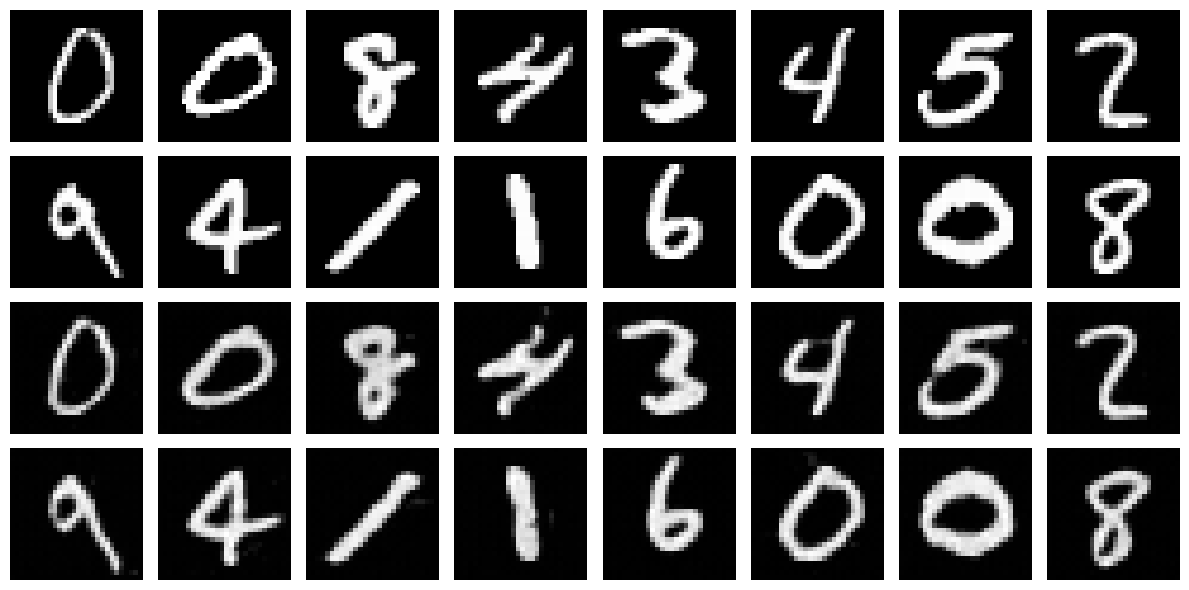

torch.Size([16, 64, 7, 7])
index: 0
tensor([[[ 8.6975e-04, -1.6994e-03,  1.4048e-03,  ..., -7.2861e-04,
          -1.6975e-03,  1.4038e-03],
         [ 8.6975e-04,  7.3624e-04, -1.7014e-03,  ...,  8.9264e-04,
           1.1978e-03, -8.6403e-04],
         [ 8.6975e-04,  1.4048e-03,  1.7481e-03,  ...,  1.4038e-03,
          -6.2561e-04, -7.2861e-04],
         ...,
         [ 8.6975e-04, -1.6994e-03,  5.6458e-04,  ...,  1.7471e-03,
          -7.3051e-04, -7.3051e-04],
         [ 8.6975e-04, -7.2861e-04,  1.4496e-04,  ...,  5.6839e-04,
          -2.8992e-04, -8.6355e-04],
         [ 1.4038e-03,  1.7395e-03,  1.7481e-03,  ..., -7.3051e-04,
           1.7395e-03,  1.4038e-03]],

        [[ 8.7738e-05,  8.1253e-04, -8.9645e-05,  ...,  1.8921e-03,
           8.1253e-04, -8.9645e-05],
         [ 8.5831e-05,  8.2785e-04,  8.1253e-04,  ...,  1.7242e-03,
           0.0000e+00, -5.0616e-04],
         [ 8.5831e-05, -8.9645e-05,  1.6479e-03,  ..., -9.1553e-05,
          -1.8311e-04,  1.8911e-03],
   

In [17]:
import matplotlib.pyplot as plt

model.eval()

# Get 16 random samples from the test split
random_indices = torch.randint(0, len(test_dataset), (16,))
samples = [test_dataset[i][0] for i in random_indices]

# Move the samples to the device
samples = torch.stack(samples).to(device)

reconstructed_samples, _, _, _ = model(samples)

# Denormalize the samples
samples = (samples * 0.5) + 0.5
reconstructed_samples = (reconstructed_samples * 0.5) + 0.5

# Visualize the original and reconstructed images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(samples[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i+16].imshow(reconstructed_samples[i].squeeze().detach().cpu(), cmap='gray')
    axes[i+16].axis('off')

plt.tight_layout()
plt.show()
x_hat, z_e, z_q, indices = model(samples)
print(z_q.shape)
for i in range(16):
    print(f"index: {i}")
    print(z_q[i])
